### 1. Import libraries

In [1]:
from ezyrb import POD, AE, GPR, RBF, Database
from ezyrb import ReducedOrderModel as ROM
import torch

from scipy.interpolate import RBFInterpolator
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np
np.bool = np.bool_ # to avoid error in pyvista

import matplotlib.pyplot as plt

from varname import nameof
import pyvista as pv

### 2. Read and preprocess of the data

In [2]:
# Assuming your data preparation steps are done here
num_simulations = 200
train_ratio = 0.8

# Load npy data from training_data folder
pressure_data = np.load('training_data/pressure_data_concat.npy')
velocity_data = np.load('training_data/velocity_data_concat.npy')
points_data = np.load('training_data/points_data.npy')

# Load design parameters from training_data folder
design_parameters = np.load('training_data/displacement_data_concat.npy')

In [3]:
random_state = 42

# randomly spit the data into training and testing data
train_pressure, test_pressure = train_test_split(pressure_data, train_size=train_ratio, random_state=random_state)
train_velocity, test_velocity = train_test_split(velocity_data, train_size=train_ratio, random_state=random_state)
train_design_parameters, test_design_parameters = train_test_split(design_parameters, train_size=train_ratio, random_state=random_state)
train_points, test_points = train_test_split(points_data, train_size=train_ratio, random_state=random_state)

In [4]:
# delete columns with all zeros in train_design_parameters
eliminate_columns = np.all(train_design_parameters == 0, axis=0)
train_design_parameters = train_design_parameters[:, ~eliminate_columns]
test_design_parameters = test_design_parameters[:, ~eliminate_columns]

### 3. AE evaluation

In [5]:
def PODI_rom(ae, model, train_design_parameters, train_data):
    # Define the database
    db = Database(train_design_parameters, train_data)
    # Define the ROM
    rom = ROM(db, ae, model)
    rom.fit()

    return rom

### 4. AE interpolation

[epoch      1]	1.012114e+00
[epoch   1000]	2.593870e-03
[epoch   2000]	8.317667e-04
[epoch   3000]	3.867655e-04
[epoch   4000]	2.305171e-04
[epoch   5000]	1.633421e-03


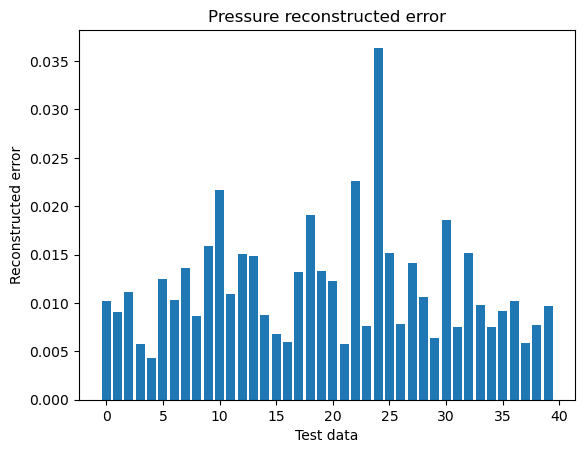

In [6]:
# Normalize the training data
p_scaler = StandardScaler()
train_pressure_scaled = p_scaler.fit_transform(train_pressure)
test_pressure_scaled = p_scaler.transform(test_pressure)

# Evaluate AE on the pressure data
low_dim = 20
optim = torch.optim.Adam
encoder_list = [200, low_dim]
decoder_list = [low_dim, 200]
encoder_activation = torch.nn.Tanh
decoder_activation = torch.nn.Tanh

p_ae = AE(encoder_list, decoder_list, encoder_activation(), decoder_activation(), 
          [5000, 1e-5], optimizer=optim, frequency_print=1000)

# Define the GPR model
p_gpr = GPR()

# Perform PODI on the pressure data
p_rom = PODI_rom(p_ae, p_gpr, train_design_parameters, train_pressure_scaled)

# Predict the pressure data
p_predict = p_rom.predict(test_design_parameters)
p_predict_data = p_scaler.inverse_transform(p_predict.snapshots_matrix)

# calculate the reconstrcuted error for each test data using mean squared error
p_reconstructed_error = np.linalg.norm(test_pressure - p_predict_data, axis=1) / np.linalg.norm(test_pressure, axis=1)

# plot the error
plt.bar([i for i in range(len(p_reconstructed_error))], p_reconstructed_error)
plt.title('Pressure reconstructed error')
plt.xlabel('Test data')
plt.ylabel('Reconstructed error')
plt.show()

In [15]:
u_error_list = []
rank_range = [i for i in range(2, 10, 2)] + [i for i in range(10, 41, 10)]

# Normalize the training data
u_scaler = StandardScaler()
train_velocity_scaled = u_scaler.fit_transform(train_velocity)

for i in rank_range:   

    # Evaluate AE on the pressure data
    low_dim = i
    optim = torch.optim.Adam
    encoder_list = [2000, low_dim]
    decoder_list = [low_dim, 2000]
    encoder_activation = torch.nn.Sigmoid
    decoder_activation = torch.nn.Sigmoid

    u_ae = AE(encoder_list, decoder_list, encoder_activation(), decoder_activation(), 
            [150, 1e-5], optimizer=optim, frequency_print=20)

    # Define the GPR model
    u_gpr = GPR()

    # Perform PODI on the pressure data
    u_rom = PODI_rom(u_ae, u_gpr, train_design_parameters, train_velocity_scaled)

    # Predict the pressure data
    u_predict_scaled = u_rom.predict(test_design_parameters)
    u_predict = u_scaler.inverse_transform(u_predict_scaled.snapshots_matrix)

    # calculate the reconstrcuted error for each test data using mean squared error
    u_error_list.append(np.linalg.norm(test_velocity - u_predict, axis=1) / np.linalg.norm(test_velocity, axis=1))

    # # plot the error
    # plt.bar([i for i in range(len(u_reconstructed_error))], u_reconstructed_error)
    # plt.title('Velocity reconstructed error')
    # plt.xlabel('Test data')
    # plt.ylabel('Reconstructed error')
    # plt.show()

[epoch      1]	1.085706e+00
[epoch     20]	5.968921e-01
[epoch     40]	5.326392e-01
[epoch     60]	5.015388e-01
[epoch     80]	4.819642e-01
[epoch    100]	4.588971e-01
[epoch    120]	4.419438e-01
[epoch    140]	4.315926e-01
[epoch    150]	4.274274e-01
[epoch      1]	1.086401e+00
[epoch     20]	3.576800e-01
[epoch     40]	2.974983e-01
[epoch     60]	2.758262e-01
[epoch     80]	2.578242e-01
[epoch    100]	2.358203e-01
[epoch    120]	2.155897e-01
[epoch    140]	2.008534e-01
[epoch    150]	1.944731e-01
[epoch      1]	1.085497e+00
[epoch     20]	3.149860e-01
[epoch     40]	1.830401e-01
[epoch     60]	1.552882e-01
[epoch     80]	1.395250e-01
[epoch    100]	1.262850e-01
[epoch    120]	1.135569e-01
[epoch    140]	1.022104e-01
[epoch    150]	9.692942e-02
[epoch      1]	1.086712e+00
[epoch     20]	2.809723e-01
[epoch     40]	1.464044e-01
[epoch     60]	1.059877e-01
[epoch     80]	8.921858e-02
[epoch    100]	8.180794e-02
[epoch    120]	7.485493e-02
[epoch    140]	6.729133e-02
[epoch    150]	6.345

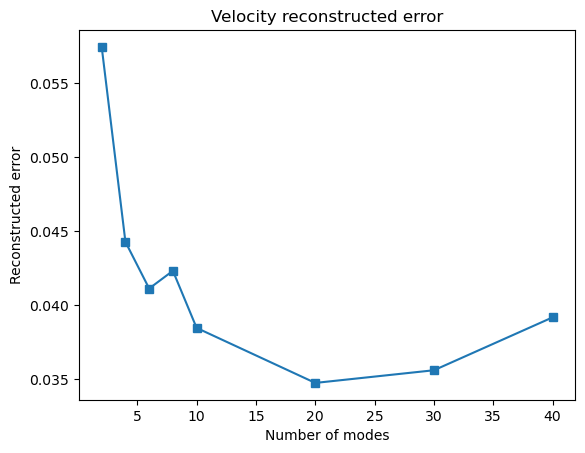

In [16]:
# print the error using different number of modes
u_error = np.array(u_error_list)
u_error_mean = np.mean(u_error, axis=1)

plt.plot(rank_range, u_error_mean, marker='s')
plt.title('Velocity reconstructed error')
plt.xlabel('Number of modes')
plt.ylabel('Reconstructed error')
plt.show()

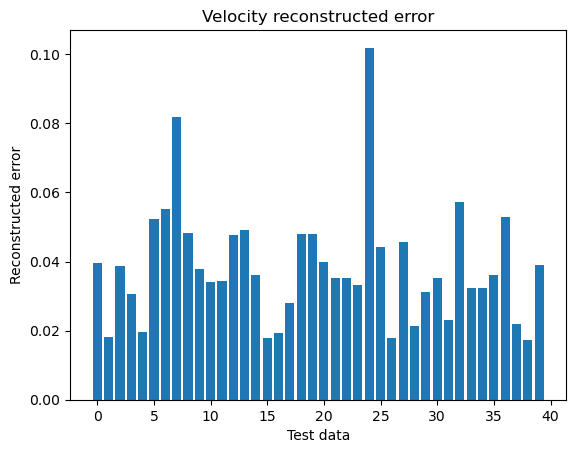

In [18]:
# plot the error of each case when using 22 modes
plt.bar([i for i in range(len(u_error_list[4]))], u_error_list[4])
plt.title('Velocity reconstructed error')
plt.xlabel('Test data')
plt.ylabel('Reconstructed error')
plt.show()

### 5. VTK visualization

In [ ]:
# Define a funtion to write the data into a VTK file
def vtk_writer(field_data, field_name, data_type,
               refVTM, save_path_name, points_data = None):
    # Add velocity data to each block within the MultiBlock dataset
    
    for block_i in range(refVTM.n_blocks):
        block = refVTM[block_i]
        if block is not None:
            if data_type == 'scalar':
                for data_i in range(len(field_name)):
                    block.cell_data[field_name[data_i]] = field_data[data_i]
            elif data_type == 'vector':
                for data_i in range(len(field_name)):
                    field = field_data[data_i].reshape(3, -1).T
                    block.cell_data[field_name[data_i]] = field 
            if points_data is not None:
                points = points_data.reshape(3, -1).T
                block.points = points

    # Save the modified VTM file
    output_vtm_file_path = f'{save_path_name}.vtm'
    refVTM.save(output_vtm_file_path)

In [18]:
# write the truth data, reconstructed data, and error into a VTK file
# Load the reference mesh VTM file
refVTM = pv.MultiBlock('simulation_data/refCase/VTK/refCase_0.vtm')
field_name = ['truth', 'reconstructed', 'error']
p_error_field = test_pressure - p_predict.snapshots_matrix

# loop all test data and write the data into VTK file
for i in range(len(test_pressure)):
    vtk_writer([test_pressure[i], p_predict.snapshots_matrix[i], p_error_field[i]], 
                field_name, 'scalar', refVTM, f'visualization_data/EZyRB_AE_GPR/test_case_{i}_pressure', test_points[i])

In [19]:
# Write the velocity data into VTK file
field_name = ['truth', 'reconstructed', 'error']
u_error_field = test_velocity - u_predict.snapshots_matrix

# loop all test data and write the data into VTK file
for i in range(len(test_velocity)):
    vtk_writer([test_velocity[i], u_predict.snapshots_matrix[i], u_error_field[i]], 
                field_name, 'vector', refVTM, f'visualization_data/EZyRB_AE_GPR/test_case_{i}_velocity', test_points[i])